In [2]:
import pandas as pd
import glob
import os
import json
import numpy as np

In [23]:
# taking nominations from all waves
path = r'../data/movez_nominations' # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))
df_nom = pd.concat((pd.read_csv(f,sep=';', header=0) for f in all_files), ignore_index=True)
df_nom

,Child,Wave,Variable,Alter
0,1420,7,GEN_Advice,1422
1,1420,7,GEN_Leader,1429
2,1421,7,GEN_Advice,1428
3,1421,7,GEN_Leader,1425
4,1421,7,GEN_Leader,1429
...,...,...,...,...
199932,2932,3,Di_Modelling_reversed,2927
199933,2932,3,Di_Modelling_reversed,2934
199934,2932,3,Di_Modelling_reversed,2936
199935,2932,3,Di_Modelling_reversed,2938


##### Note: We need to take into consideration the fact that different participants can receive a different maximum number of nominations, based on the participation wave and the number of pulips that can nominate them (depending on school/grade that they are part of etc..). For each participant we need the pool of people that can nominate them.

In [4]:
# number of questions used per wave 
df_nom.groupby('Wave')['Variable'].nunique(), df_nom.groupby('Wave')['Child'].nunique(), df_nom.groupby('Wave')['Alter'].nunique()

(Wave
 1    13
 2    13
 3    15
 4    13
 5     6
 6     6
 7     6
 Name: Variable, dtype: int64,
 Wave
 1    816
 2    819
 3    768
 4    578
 5    736
 6    683
 7    564
 Name: Child, dtype: int64,
 Wave
 1    2077
 2    2064
 3    2106
 4    1280
 5    1040
 6    1033
 7    1034
 Name: Alter, dtype: int64)

In [5]:
df_nom['Variable'].nunique(),df_nom['Child'].nunique(),df_nom['Alter'].nunique()

(15, 1477, 3130)

##### Q: why is this significant difference between Child and Alter? Are there this many children that had IDs but were not part of the project? Let's check the intersection between these two set of IDs next

In [4]:
len(set(df_nom['Child'].unique()).intersection(set(df_nom['Alter'].unique())))

1470

In [5]:
participant_IDs = list(set(df_nom['Child'].unique()).intersection(set(df_nom['Alter'].unique())))

In [6]:
len(participant_IDs)

1470

##### Check how it matches the participants file 

In [7]:
df_pp = pd.read_csv('../data/movez_metadata/Participant_Info.csv', sep=';', header=0)
df_pp['Child'].nunique()

1484

In [8]:
len(set(set(df_pp['Child'].unique())).intersection(participant_IDs))

1470

##### Seems like the connections_all file doesn't contain all the possible nomination questions (13 out of 15). Is there any good reason for this?

In [16]:
formula = json.loads(open('../input/connections_all_new.json').read())
max_score = sum(formula.values())
max_score

15

In [17]:
# Non repeating nominations
connections_dict = {}
for child in participant_IDs:
    connections_dict[child] = {}
df_nom = df_nom[df_nom['Child'].isin(participant_IDs)]
# To avoid repetition of nominations from the same alter in different waves
nominations_list = []

for line in df_nom[['Child', 'Alter', 'Variable']].iterrows():
    (ch, nom, var) = line[1]  
    if (ch, nom, var) not in nominations_list:
        connections_dict[ch][nom] = connections_dict[ch].get(nom, 0) + 1*formula[var]
        nominations_list.append((ch, nom, var))

In [28]:
connections_df = pd.DataFrame(connections_dict).fillna(0)
connections_df = connections_df.T

In [29]:
len(connections_dict.keys())

1470

In [30]:
connections_df['total'] = connections_df.sum(axis=1)
connections_df

,900,903,904,907,892,918,921,924,1008,911,...,6177,6181,6162,6178,6164,6179,6180,6183,6174,total
902,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
904,1.0,2.0,0.0,3.0,2.0,7.0,3.0,3.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0
907,8.0,5.0,4.0,0.0,6.0,1.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0
908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
909,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0,6.0,13.0
6181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,25.0
6182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0
6183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,2.0,19.0


<AxesSubplot:ylabel='Frequency'>

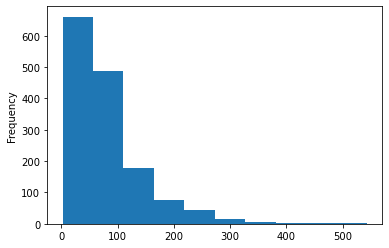

In [31]:
connections_df['total'].plot(kind="hist")

In [22]:
connections_df['total'].describe()

count    1470.000000
mean       79.156463
std        63.119140
min         2.000000
25%        34.000000
50%        62.000000
75%       102.000000
max       543.000000
Name: total, dtype: float64

<AxesSubplot:ylabel='Density'>

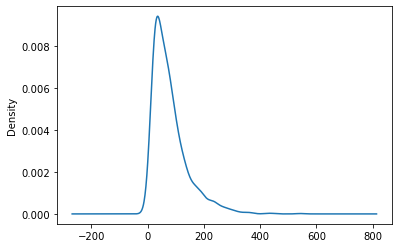

In [23]:
connections_df['total'].plot(kind='kde')

In [24]:
# simple threshold calculation get the 90th percentile of values as influencers

In [25]:
np.percentile(connections_df['total'], 90)

162.10000000000014

In [32]:
# 149 people (out of 1477) have more than 200 nominations
connections_df[connections_df['total'] >= 162]

,900,903,904,907,892,918,921,924,1008,911,...,6177,6181,6162,6178,6164,6179,6180,6183,6174,total
953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,235.0
1036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,191.0
1055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225.0
1094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,238.0
1102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,290.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212.0
3209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189.0
3259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,258.0
3317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,173.0


In [27]:
influencers_id = list(connections_df[connections_df['total'] >= 162].index)
non_influencers_id = list(connections_df[connections_df['total'] < 162].index)

#### Updated calculation: check per wave the number of potential nominations a participant can receive. The maximum number of nominations is the number of participants per school (Thabo). Approx 10% of nominations should be out of class (according to Thabo), test this here. 

In [243]:
# taking nominations from all waves
path = r'../data/movez_nominations' # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))
df_nom = pd.concat((pd.read_csv(f,sep=';', header=0) for f in all_files), ignore_index=True)
df_nom

,Child,Wave,Variable,Alter
0,1420,7,GEN_Advice,1422
1,1420,7,GEN_Leader,1429
2,1421,7,GEN_Advice,1428
3,1421,7,GEN_Leader,1425
4,1421,7,GEN_Leader,1429
...,...,...,...,...
199932,2932,3,Di_Modelling_reversed,2927
199933,2932,3,Di_Modelling_reversed,2934
199934,2932,3,Di_Modelling_reversed,2936
199935,2932,3,Di_Modelling_reversed,2938


##### First remove the 'extra' Alter children

In [244]:
lst_participants = list(set(df_nom['Child'].unique()).intersection(set(df_nom['Alter'].unique())))
len(lst_participants)

1470

In [245]:
df_nom = df_nom[(df_nom.Child.isin(lst_participants)) & (df_nom.Alter.isin(lst_participants)) ]

In [246]:
df_nom['Variable'].nunique(),df_nom['Child'].nunique(),df_nom['Alter'].nunique()

(15, 1463, 1469)

In [247]:
df_pp = pd.read_csv('../data/movez_metadata/Participant_Info.csv', sep=';', header=0)
df_pp.shape

(1484, 19)

In [248]:
df_pp = df_pp[(df_pp.Child.isin(lst_participants))]
df_pp.shape

(1470, 19)

In [249]:
df_pp.head(3)

,School,Level,Class_Y1,Class_Y2,Class_Y3,Child,Sex,Sex_f,Age_W1,Age_W5,W1,W2,W3,W4,W5,W6,W7,Y1_Sample,Y3_Sample
0,22,Secondary,52.0,52.0,NaN,902,1,Female,13.0,NaN,1,1,0,0,0,0,0,1,0
1,22,Secondary,52.0,52.0,NaN,904,1,Female,12.0,NaN,1,1,0,0,0,0,0,1,0
2,22,Secondary,52.0,52.0,NaN,907,1,Female,12.0,NaN,1,1,0,0,0,0,0,1,0


In [250]:
df_pp['num_per_school'] = df_pp.School.map(df_pp.groupby(['School'])['Level'].count())

In [251]:
df_pp['num_per_class_Y1'] = df_pp.Class_Y1.map(df_pp.groupby(['Class_Y1'])['Level'].count())
df_pp['num_per_class_Y2'] = df_pp.Class_Y2.map(df_pp.groupby(['Class_Y2'])['Level'].count())
df_pp['num_per_class_Y3'] = df_pp.Class_Y3.map(df_pp.groupby(['Class_Y3'])['Level'].count())

In [252]:
df_pp.head(15)

,School,Level,Class_Y1,Class_Y2,Class_Y3,Child,Sex,Sex_f,Age_W1,Age_W5,...,W4,W5,W6,W7,Y1_Sample,Y3_Sample,num_per_school,num_per_class_Y1,num_per_class_Y2,num_per_class_Y3
0,22,Secondary,52.0,52.0,NaN,902,1,Female,13.0,NaN,...,0,0,0,0,1,0,31,5.0,3.0,NaN
1,22,Secondary,52.0,52.0,NaN,904,1,Female,12.0,NaN,...,0,0,0,0,1,0,31,5.0,3.0,NaN
2,22,Secondary,52.0,52.0,NaN,907,1,Female,12.0,NaN,...,0,0,0,0,1,0,31,5.0,3.0,NaN
3,22,Secondary,52.0,55.0,NaN,908,0,Male,12.0,NaN,...,1,0,0,0,1,0,31,5.0,8.0,NaN
4,22,Secondary,52.0,55.0,NaN,909,0,Male,12.0,NaN,...,1,0,0,0,1,0,31,5.0,8.0,NaN
6,22,Secondary,54.0,54.0,NaN,935,0,Male,13.0,NaN,...,1,0,0,0,1,0,31,6.0,5.0,NaN
7,22,Secondary,54.0,54.0,NaN,936,0,Male,13.0,NaN,...,0,0,0,0,1,0,31,6.0,5.0,NaN
8,22,Secondary,54.0,NaN,NaN,942,1,Female,13.0,NaN,...,1,0,0,0,1,0,31,6.0,NaN,NaN
9,22,Secondary,54.0,54.0,NaN,944,0,Male,13.0,NaN,...,0,0,0,0,1,0,31,6.0,5.0,NaN
10,22,Secondary,54.0,54.0,NaN,947,1,Female,12.0,NaN,...,1,0,0,0,1,0,31,6.0,5.0,NaN


In [253]:
# mapping the necessary columns
df_nom['Child_School'] = df_nom['Child'].map(df_pp.set_index('Child')['School'])
df_nom['Child_School_Participants'] = df_nom['Child'].map(df_pp.set_index('Child')['num_per_school'])
df_nom['Child_Class_Y1'] = df_nom['Child'].map(df_pp.set_index('Child')['Class_Y1'])
df_nom['Child_Class_Y2'] = df_nom['Child'].map(df_pp.set_index('Child')['Class_Y2'])
df_nom['Child_Class_Y3'] = df_nom['Child'].map(df_pp.set_index('Child')['Class_Y3'])
df_nom['Child_num_per_class_Y1'] = df_nom['Child'].map(df_pp.set_index('Child')['num_per_class_Y1'])
df_nom['Child_num_per_class_Y2'] = df_nom['Child'].map(df_pp.set_index('Child')['num_per_class_Y2'])
df_nom['Child_num_per_class_Y3'] = df_nom['Child'].map(df_pp.set_index('Child')['num_per_class_Y3'])

df_nom['Alter_School'] = df_nom['Alter'].map(df_pp.set_index('Child')['School'])
df_nom['Alter_School_Participants'] = df_nom['Alter'].map(df_pp.set_index('Child')['num_per_school'])
df_nom['Alter_Class_Y1'] = df_nom['Alter'].map(df_pp.set_index('Child')['Class_Y1'])
df_nom['Alter_Class_Y2'] = df_nom['Alter'].map(df_pp.set_index('Child')['Class_Y2'])
df_nom['Alter_Class_Y3'] = df_nom['Alter'].map(df_pp.set_index('Child')['Class_Y3'])
df_nom['Alter_num_per_class_Y1'] = df_nom['Alter'].map(df_pp.set_index('Child')['num_per_class_Y1'])
df_nom['Alter_num_per_class_Y2'] = df_nom['Alter'].map(df_pp.set_index('Child')['num_per_class_Y2'])
df_nom['Alter_num_per_class_Y3'] = df_nom['Alter'].map(df_pp.set_index('Child')['num_per_class_Y3'])

df_nom['questions_per_wave'] = df_nom.Wave.map(df_nom.groupby(['Wave'])['Variable'].nunique())


df_nom.head(3)

/var/folders/t4/v59wrn6n2ws6kl1t9zh1q_mc0000gn/T/ipykernel_19679/2044120642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nom['Child_School'] = df_nom['Child'].map(df_pp.set_index('Child')['School'])
/var/folders/t4/v59wrn6n2ws6kl1t9zh1q_mc0000gn/T/ipykernel_19679/2044120642.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nom['Child_School_Participants'] = df_nom['Child'].map(df_pp.set_index('Child')['num_per_school'])
/var/folders/t4/v59wrn6n2ws6kl1t9zh1q_mc0000gn/T/ipykernel_19679/20441206

,Child,Wave,Variable,Alter,Child_School,Child_School_Participants,Child_Class_Y1,Child_Class_Y2,Child_Class_Y3,Child_num_per_class_Y1,...,Child_num_per_class_Y3,Alter_School,Alter_School_Participants,Alter_Class_Y1,Alter_Class_Y2,Alter_Class_Y3,Alter_num_per_class_Y1,Alter_num_per_class_Y2,Alter_num_per_class_Y3,questions_per_wave
0,1420,7,GEN_Advice,1422,26,23,74.0,74.0,74.0,12.0,...,13.0,26,23,74.0,74.0,74.0,12.0,14.0,13.0,6
1,1420,7,GEN_Leader,1429,26,23,74.0,74.0,74.0,12.0,...,13.0,26,23,74.0,74.0,74.0,12.0,14.0,13.0,6
2,1421,7,GEN_Advice,1428,26,23,74.0,74.0,74.0,12.0,...,13.0,26,23,74.0,74.0,74.0,12.0,14.0,13.0,6


##### Check for same class and same school nominations

In [254]:
(df_nom['Child_School'] == df_nom['Alter_School']).value_counts()

True    135848
dtype: int64

In [255]:
df_nom_nonnan_y1 = df_nom.dropna(subset=['Alter_Class_Y1', 'Child_Class_Y1'])
df_nom_nonnan_y2 = df_nom.dropna(subset=['Alter_Class_Y2', 'Child_Class_Y2'])
df_nom_nonnan_y3 = df_nom.dropna(subset=['Alter_Class_Y3', 'Child_Class_Y3'])

In [256]:
(df_nom_nonnan_y1['Child_Class_Y1'] == df_nom_nonnan_y1['Alter_Class_Y1']).value_counts()

True     99150
False     8874
dtype: int64

In [257]:
(df_nom_nonnan['Child_Class_Y2'] == df_nom_nonnan['Alter_Class_Y2']).value_counts()

True     94295
False    13930
dtype: int64

In [258]:
(df_nom_nonnan_y3['Child_Class_Y3'] == df_nom_nonnan_y3['Alter_Class_Y3']).value_counts()

True     109809
False     16524
dtype: int64

##### Result: about 10% of nominations are coming from out of class. For simplicity of the calculation it might be better to keep only within class influencer calculation.

In [259]:
df_summed_nom = df_nom.groupby(['Child','Alter','Wave'])['Wave'].count().reset_index(name='num_nominations')

In [260]:
df_summed_nom

,Child,Alter,Wave,num_nominations
0,902,904,1,2
1,902,907,1,2
2,904,902,1,1
3,904,907,1,3
4,904,908,1,1
...,...,...,...,...
50315,6186,5451,7,1
50316,6186,5452,7,1
50317,6186,5453,7,1
50318,6186,5454,7,2


In [261]:
df_summed_nom['Child_School'] = df_summed_nom['Child'].map(df_pp.set_index('Child')['School'])
df_summed_nom['Child_School_Participants'] = df_nom['Child'].map(df_pp.set_index('Child')['num_per_school'])
df_summed_nom['Child_Class_Y1'] = df_summed_nom['Child'].map(df_pp.set_index('Child')['Class_Y1'])
df_summed_nom['Child_Class_Y2'] = df_summed_nom['Child'].map(df_pp.set_index('Child')['Class_Y2'])
df_summed_nom['Child_Class_Y3'] = df_summed_nom['Child'].map(df_pp.set_index('Child')['Class_Y3'])
df_summed_nom['Child_num_per_class_Y1'] = df_summed_nom['Child'].map(df_pp.set_index('Child')['num_per_class_Y1'])
df_summed_nom['Child_num_per_class_Y2'] = df_summed_nom['Child'].map(df_pp.set_index('Child')['num_per_class_Y2'])
df_summed_nom['Child_num_per_class_Y3'] = df_summed_nom['Child'].map(df_pp.set_index('Child')['num_per_class_Y3'])

df_summed_nom['Alter_School'] = df_summed_nom['Alter'].map(df_pp.set_index('Child')['School'])
df_summed_nom['Alter_School_Participants'] = df_summed_nom['Alter'].map(df_pp.set_index('Child')['num_per_school'])
df_summed_nom['Alter_Class_Y1'] = df_summed_nom['Alter'].map(df_pp.set_index('Child')['Class_Y1'])
df_summed_nom['Alter_Class_Y2'] = df_summed_nom['Alter'].map(df_pp.set_index('Child')['Class_Y2'])
df_summed_nom['Alter_Class_Y3'] = df_summed_nom['Alter'].map(df_pp.set_index('Child')['Class_Y3'])
df_summed_nom['Alter_num_per_class_Y1'] = df_nom['Alter'].map(df_pp.set_index('Child')['num_per_class_Y1'])
df_summed_nom['Alter_num_per_class_Y2'] = df_nom['Alter'].map(df_pp.set_index('Child')['num_per_class_Y2'])
df_summed_nom['Alter_num_per_class_Y3'] = df_nom['Alter'].map(df_pp.set_index('Child')['num_per_class_Y3'])
df_summed_nom['questions_per_wave'] = df_summed_nom.Wave.map(df_nom.groupby(['Wave'])['Variable'].nunique())

In [262]:
df_summed_nom

,Child,Alter,Wave,num_nominations,Child_School,Child_School_Participants,Child_Class_Y1,Child_Class_Y2,Child_Class_Y3,Child_num_per_class_Y1,...,Child_num_per_class_Y3,Alter_School,Alter_School_Participants,Alter_Class_Y1,Alter_Class_Y2,Alter_Class_Y3,Alter_num_per_class_Y1,Alter_num_per_class_Y2,Alter_num_per_class_Y3,questions_per_wave
0,902,904,1,2,22,23.0,52.0,52.0,NaN,5.0,...,NaN,22,31,52.0,52.0,NaN,12.0,14.0,13.0,13
1,902,907,1,2,22,23.0,52.0,52.0,NaN,5.0,...,NaN,22,31,52.0,52.0,NaN,12.0,14.0,13.0,13
2,904,902,1,1,22,23.0,52.0,52.0,NaN,5.0,...,NaN,22,31,52.0,52.0,NaN,12.0,14.0,13.0,13
3,904,907,1,3,22,NaN,52.0,52.0,NaN,5.0,...,NaN,22,31,52.0,52.0,NaN,NaN,NaN,NaN,13
4,904,908,1,1,22,23.0,52.0,52.0,NaN,5.0,...,NaN,22,31,52.0,55.0,NaN,12.0,14.0,13.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50315,6186,5451,7,1,29,NaN,NaN,NaN,272.0,NaN,...,27.0,29,81,NaN,NaN,272.0,NaN,NaN,NaN,6
50316,6186,5452,7,1,29,NaN,NaN,NaN,272.0,NaN,...,27.0,29,81,NaN,NaN,272.0,NaN,NaN,NaN,6
50317,6186,5453,7,1,29,31.0,NaN,NaN,272.0,NaN,...,27.0,29,81,NaN,NaN,272.0,8.0,6.0,NaN,6
50318,6186,5454,7,2,29,31.0,NaN,NaN,272.0,NaN,...,27.0,29,81,NaN,NaN,272.0,8.0,NaN,NaN,6


In [263]:
df_summed_nom['sameClassY1'] = np.select([(df_summed_nom['Alter_Class_Y1'].isnull() | df_summed_nom['Child_Class_Y1'].isnull()),(df_summed_nom.Child_Class_Y1 == df_summed_nom.Alter_Class_Y1),(df_summed_nom.Child_Class_Y1 != df_summed_nom.Alter_Class_Y1),],[-1,1,0])
df_summed_nom['sameClassY2'] = np.select([(df_summed_nom['Alter_Class_Y2'].isnull() | df_summed_nom['Child_Class_Y2'].isnull()),(df_summed_nom.Child_Class_Y2 == df_summed_nom.Alter_Class_Y2),(df_summed_nom.Child_Class_Y2 != df_summed_nom.Alter_Class_Y2),],[-1,1,0])
df_summed_nom['sameClassY3'] = np.select([(df_summed_nom['Alter_Class_Y3'].isnull() | df_summed_nom['Child_Class_Y3'].isnull()),(df_summed_nom.Child_Class_Y3 == df_summed_nom.Alter_Class_Y3),(df_summed_nom.Child_Class_Y3 != df_summed_nom.Alter_Class_Y3),],[-1,1,0])

In [264]:
df_summed_nom.groupby('sameClassY1')['Child'].count(),df_summed_nom.groupby('sameClassY2')['Child'].count(),df_summed_nom.groupby('sameClassY3')['Child'].count()

(sameClassY1
 -1    14890
  0     5198
  1    30232
 Name: Child, dtype: int64,
 sameClassY2
 -1    14558
  0     6722
  1    29040
 Name: Child, dtype: int64,
 sameClassY3
 -1     3203
  0     7573
  1    39544
 Name: Child, dtype: int64)

##### let's take only the within class nominations

In [265]:
df_valid_noms = df_summed_nom[(df_summed_nom.sameClassY1 == 1) & (df_summed_nom.sameClassY2 == 1) & (df_summed_nom.sameClassY3 == 1)]

In [266]:
df_valid_noms

,Child,Alter,Wave,num_nominations,Child_School,Child_School_Participants,Child_Class_Y1,Child_Class_Y2,Child_Class_Y3,Child_num_per_class_Y1,...,Alter_Class_Y1,Alter_Class_Y2,Alter_Class_Y3,Alter_num_per_class_Y1,Alter_num_per_class_Y2,Alter_num_per_class_Y3,questions_per_wave,sameClassY1,sameClassY2,sameClassY3
253,1046,1047,1,1,23,81.0,59.0,59.0,311.0,10.0,...,59.0,59.0,311.0,28.0,29.0,28.0,13,1,1,1
254,1046,1047,3,1,23,81.0,59.0,59.0,311.0,10.0,...,59.0,59.0,311.0,28.0,29.0,28.0,15,1,1,1
255,1046,1047,4,1,23,81.0,59.0,59.0,311.0,10.0,...,59.0,59.0,311.0,28.0,29.0,28.0,13,1,1,1
256,1046,1050,1,2,23,81.0,59.0,59.0,311.0,10.0,...,59.0,59.0,311.0,28.0,29.0,28.0,13,1,1,1
257,1046,1050,2,1,23,81.0,59.0,59.0,311.0,10.0,...,59.0,59.0,311.0,28.0,29.0,28.0,13,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49802,6138,4889,6,5,40,127.0,131.0,131.0,131.0,21.0,...,131.0,131.0,131.0,20.0,19.0,18.0,6,1,1,1
49803,6138,4890,5,1,40,127.0,131.0,131.0,131.0,21.0,...,131.0,131.0,131.0,20.0,19.0,18.0,6,1,1,1
49804,6138,4890,6,3,40,NaN,131.0,131.0,131.0,21.0,...,131.0,131.0,131.0,NaN,NaN,NaN,6,1,1,1
49805,6138,6135,5,4,40,NaN,131.0,131.0,131.0,21.0,...,131.0,131.0,131.0,NaN,NaN,NaN,6,1,1,1


In [267]:
df_valid_noms = df_valid_noms.groupby(['Child','Wave','Child_num_per_class_Y1','Child_num_per_class_Y2','Child_num_per_class_Y3','questions_per_wave'])['num_nominations'].sum().reset_index(name='nominations_per_wave')

In [268]:
df_valid_noms['total_nominations'] = df_valid_noms.Child.map(df_valid_noms.groupby(['Child'])['nominations_per_wave'].sum())
df_valid_noms

,Child,Wave,Child_num_per_class_Y1,Child_num_per_class_Y2,Child_num_per_class_Y3,questions_per_wave,nominations_per_wave,total_nominations
0,1046,1,10.0,10.0,36.0,13,4,21
1,1046,2,10.0,10.0,36.0,13,5,21
2,1046,3,10.0,10.0,36.0,15,4,21
3,1046,4,10.0,10.0,36.0,13,8,21
4,1047,1,10.0,10.0,36.0,13,11,17
...,...,...,...,...,...,...,...,...
2896,6137,5,21.0,21.0,21.0,6,13,31
2897,6137,6,21.0,21.0,21.0,6,5,31
2898,6137,7,21.0,21.0,21.0,6,13,31
2899,6138,5,21.0,21.0,21.0,6,15,30
